# OpenAI Completions Usage API Extended Example

This notebook demonstrates how to retrieve and visualize usage data from the OpenAI Completions Usage API and Costs API. We'll:
- Call the API to get completions usage data.
- Parse the JSON response into a pandas DataFrame.
- Visualize token usage over time using matplotlib.
- Use grouping by model to analyze token usage across different models.
- Display model distribution with a pie chart.

We also include placeholders for all possible API parameters for a comprehensive overview.

In [13]:
# Install required libraries (if not already installed)
!pip install requests pandas numpy matplotlib --quiet

# Import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import json

# For inline plotting in Jupyter
%matplotlib inline


## Setup API Credentials and Parameters

Set up an Admin Key - https://platform.openai.com/settings/organization/admin-keys

Replace `'PLACEHOLDER'` with your actual ADMIN API key. It's best practice to load the key from an environment variable for security.


In [3]:
# Set up the API key and headers
OPENAI_ADMIN_KEY = '<PLACEHOLDER>'  

headers = {
    "Authorization": f"Bearer {OPENAI_ADMIN_KEY}",
    "Content-Type": "application/json"
}

# Define the API endpoint
url = "https://api.openai.com/v1/organization/usage/completions"

# Calculate start time: n days ago from now
days_ago = 30
start_time = int(time.time()) - (days_ago * 24 * 60 * 60)

# Define parameters with placeholders for all possible options
params = {
    "start_time": start_time,  # Required: Start time (Unix seconds)
    # "end_time": end_time,  # Optional: End time (Unix seconds)
    "bucket_width": "1d",      # Optional: '1m', '1h', or '1d' (default '1d')
    # "project_ids": ["proj_example"],  # Optional: List of project IDs
    # "user_ids": ["user_example"],     # Optional: List of user IDs
    # "api_key_ids": ["key_example"],   # Optional: List of API key IDs
    # "models": ["gpt-4o-mini-2024-07-18"],  # Optional: List of models
    # "batch": False,             # Optional: True for batch jobs, False for non-batch
    # "group_by": ["model"],     # Optional: Fields to group by
    "limit": 7,                 # Optional: Number of buckets to return, this will chunk the data into 7 buckets
    # "page": "cursor_string"   # Optional: Cursor for pagination
}

# Initialize an empty list to store all data
all_data = []

# Initialize pagination cursor
page_cursor = None

# Loop to handle pagination
while True:
    # Update the page cursor in parameters if it exists
    if page_cursor:
        params["page"] = page_cursor

    # Make the API request
    response = requests.get(url, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data_json = response.json()
        all_data.extend(data_json.get("data", []))  # Append current page data to all_data

        # Check if there's a next page
        page_cursor = data_json.get("next_page")
        if not page_cursor:
            break  # Exit loop if no more pages
    else:
        print(f"Error: {response.status_code}")
        break  # Exit loop on error

if all_data:
    print("Data retrieved successfully!")
else:
    print("Issue: No data available to retrieve.")

Data retrieved successfully!


## Inspect the JSON Response

Let's take a look at the raw JSON response from the API to understand its structure.


In [4]:
print(json.dumps(all_data, indent=2))

[
  {
    "object": "bucket",
    "start_time": 1734345977,
    "end_time": 1734393600,
    "results": [
      {
        "object": "organization.usage.completions.result",
        "input_tokens": 300245,
        "output_tokens": 534874,
        "num_model_requests": 298,
        "project_id": null,
        "user_id": null,
        "api_key_id": null,
        "model": null,
        "batch": null,
        "service_tier": null,
        "input_cached_tokens": 53120,
        "input_audio_tokens": 0,
        "output_audio_tokens": 0
      }
    ]
  },
  {
    "object": "bucket",
    "start_time": 1734393600,
    "end_time": 1734480000,
    "results": [
      {
        "object": "organization.usage.completions.result",
        "input_tokens": 8,
        "output_tokens": 9,
        "num_model_requests": 1,
        "project_id": null,
        "user_id": null,
        "api_key_id": null,
        "model": null,
        "batch": null,
        "service_tier": null,
        "input_cached_tokens": 0,

## Parse the API Response and Create a DataFrame

Now we will parse the JSON data, extract relevant fields, and create a pandas DataFrame for easier manipulation and analysis.

In [5]:
# Initialize a list to hold parsed records
records = []

# Iterate through the data to extract bucketed data
for bucket in all_data:  
    start_time = bucket.get("start_time")
    end_time = bucket.get("end_time")
    for result in bucket.get("results", []):
        records.append({
            "start_time": start_time,
            "end_time": end_time,
            "input_tokens": result.get("input_tokens", 0),
            "output_tokens": result.get("output_tokens", 0),
            "input_cached_tokens": result.get("input_cached_tokens", 0),
            "input_audio_tokens": result.get("input_audio_tokens", 0),
            "output_audio_tokens": result.get("output_audio_tokens", 0),
            "num_model_requests": result.get("num_model_requests", 0),
            "project_id": result.get("project_id"),
            "user_id": result.get("user_id"),
            "api_key_id": result.get("api_key_id"),
            "model": result.get("model"),
            "batch": result.get("batch"),
            "service_tier": result.get("service_tier")
        })

# Create a DataFrame from the records
df = pd.DataFrame(records)

# Convert Unix timestamps to datetime for readability
df['start_datetime'] = pd.to_datetime(df['start_time'], unit='s')
df['end_datetime'] = pd.to_datetime(df['end_time'], unit='s')

# Reorder columns for better readability
df = df[
    [
        "start_datetime", "end_datetime", "start_time", "end_time",
        "input_tokens", "output_tokens", "input_cached_tokens",
        "input_audio_tokens", "output_audio_tokens", "num_model_requests",
        "project_id", "user_id", "api_key_id", "model", "batch", "service_tier"
    ]
]

# Display the DataFrame
df.head()

,start_datetime,end_datetime,start_time,end_time,input_tokens,output_tokens,input_cached_tokens,input_audio_tokens,output_audio_tokens,num_model_requests,project_id,user_id,api_key_id,model,batch,service_tier
0,2024-12-16 10:46:17,2024-12-17,1734345977,1734393600,300245,534874,53120,0,0,298,None,None,None,None,None,None
1,2024-12-17 00:00:00,2024-12-18,1734393600,1734480000,8,9,0,0,0,1,None,None,None,None,None,None
2,2024-12-18 00:00:00,2024-12-19,1734480000,1734566400,19287,1770,15104,47248,6403,24,None,None,None,None,None,None
3,2024-12-19 00:00:00,2024-12-20,1734566400,1734652800,19162,5115,3584,21218,12483,38,None,None,None,None,None,None
4,2024-12-20 00:00:00,2024-12-21,1734652800,1734739200,50882,24867,0,0,0,28,None,None,None,None,None,None


## Visualize Token Usage Over Time

We'll create a bar chart to visualize input and output token usage for each time bucket.


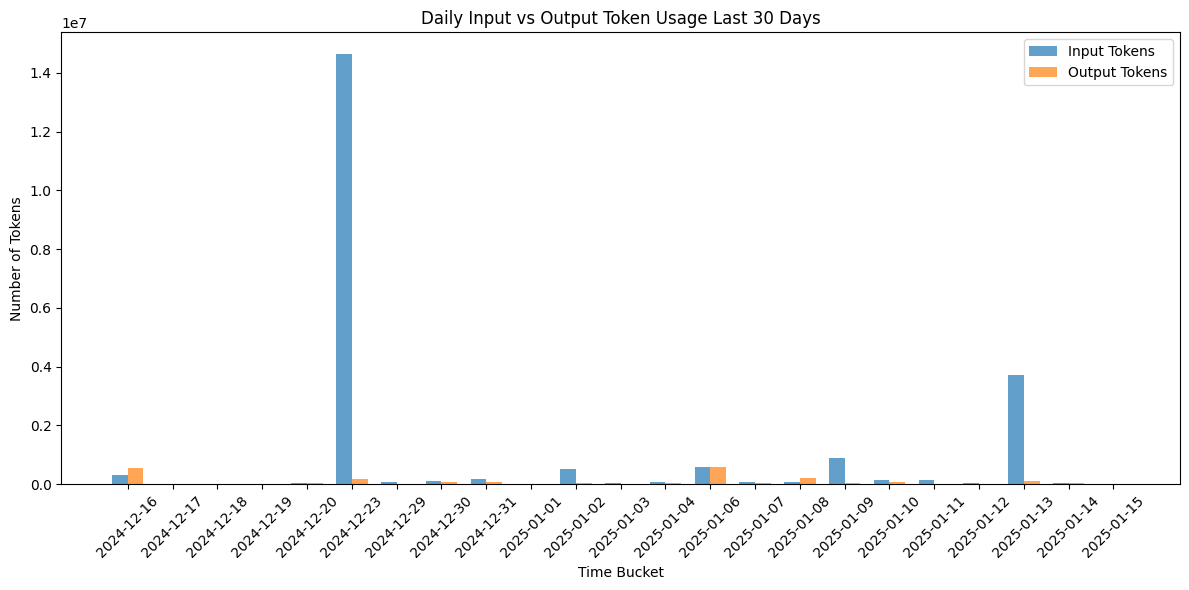

In [6]:
if not df.empty:
    plt.figure(figsize=(12, 6))
    
    # Create bar charts for input and output tokens
    width = 0.35  # width of the bars
    indices = range(len(df))
    
    plt.bar(indices, df['input_tokens'], width=width, label='Input Tokens', alpha=0.7)
    plt.bar([i + width for i in indices], df['output_tokens'], width=width, label='Output Tokens', alpha=0.7)
    
    # Set labels and ticks
    plt.xlabel('Time Bucket')
    plt.ylabel('Number of Tokens')
    plt.title('Daily Input vs Output Token Usage Last 30 Days')
    plt.xticks([i + width/2 for i in indices], [dt.strftime('%Y-%m-%d') for dt in df['start_datetime']], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot.")


## Visual Example: Grouping by Model

In this section, we retrieve and visualize usage data grouped by model and project_id. This can help you see the total tokens used by each model over the specified period.

### Note on Grouping Parameter

- If you do not specify a `group_by` parameter, fields such as `project_id`, `model`, and others will return as `null`. 
  Although the `group_by` parameter is optional, it is recommended to include it in most cases to retrieve meaningful data.
  
- You can specify multiple group fields by separating them with commas. For example: `group_by=["model", "project_id"]`.

In [7]:
# Calculate start time: n days ago from now
days_ago = 30
start_time = int(time.time()) - (days_ago * 24 * 60 * 60)

# Define parameters with grouping by model and project_id
params = {
    "start_time": start_time,         # Required: Start time (Unix seconds)
    "bucket_width": "1d",            # Optional: '1m', '1h', or '1d' (default '1d')
    "group_by": ["model", "project_id"],  # Group data by model and project_id
    "limit": 7                       # Optional: Number of buckets to return
}

# Initialize an empty list to store all data
all_group_data = []

# Initialize pagination cursor
page_cursor = None

# Loop to handle pagination
while True:
    # Update the page cursor in parameters if it exists
    if page_cursor:
        params["page"] = page_cursor

    # Make the API request
    response = requests.get(url, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data_json = response.json()
        all_group_data.extend(data_json.get("data", []))  # Append current page data to all_data

        # Check if there's a next page
        page_cursor = data_json.get("next_page")
        if not page_cursor:
            break  # Exit loop if no more pages
    else:
        print(f"Error: {response.status_code}")
        break  # Exit loop on error

if all_group_data:
    print("Data retrieved successfully!")
else:
    print("Issue: No data available to retrieve.")

# Initialize a list to hold parsed records
records = []

# Iterate through the data to extract bucketed data
for bucket in all_group_data:
    start_time = bucket.get("start_time")
    end_time = bucket.get("end_time")
    for result in bucket.get("results", []):
        records.append({
            "start_time": start_time,
            "end_time": end_time,
            "input_tokens": result.get("input_tokens", 0),
            "output_tokens": result.get("output_tokens", 0),
            "input_cached_tokens": result.get("input_cached_tokens", 0),
            "input_audio_tokens": result.get("input_audio_tokens", 0),
            "output_audio_tokens": result.get("output_audio_tokens", 0),
            "num_model_requests": result.get("num_model_requests", 0),
            "project_id": result.get("project_id", "N/A"),
            "user_id": result.get("user_id", "N/A"),
            "api_key_id": result.get("api_key_id", "N/A"),
            "model": result.get("model", "N/A"),
            "batch": result.get("batch", "N/A"),
            "service_tier": result.get("service_tier", "N/A")
        })

# Create a DataFrame from the records
df = pd.DataFrame(records)

# Convert Unix timestamps to datetime for readability
df['start_datetime'] = pd.to_datetime(df['start_time'], unit='s', errors='coerce')
df['end_datetime'] = pd.to_datetime(df['end_time'], unit='s', errors='coerce')

# Reorder columns for better readability
df = df[
    [
        "start_datetime", "end_datetime", "start_time", "end_time",
        "input_tokens", "output_tokens", "input_cached_tokens",
        "input_audio_tokens", "output_audio_tokens", "num_model_requests",
        "project_id", "user_id", "api_key_id", "model", "batch", "service_tier"
    ]
]

# Display the DataFrame
df.head()

Data retrieved successfully!


,start_datetime,end_datetime,start_time,end_time,input_tokens,output_tokens,input_cached_tokens,input_audio_tokens,output_audio_tokens,num_model_requests,project_id,user_id,api_key_id,model,batch,service_tier
0,2024-12-16 10:46:29,2024-12-17,1734345989,1734393600,22483,15488,0,0,0,32,proj_frFrNmknEESBPFLqlnYutIA9,None,None,gpt-4o-2024-08-06,None,None
1,2024-12-16 10:46:29,2024-12-17,1734345989,1734393600,22454,4399,0,0,0,32,proj_frFrNmknEESBPFLqlnYutIA9,None,None,gpt-3.5-turbo-0125,None,None
2,2024-12-16 10:46:29,2024-12-17,1734345989,1734393600,380,848,0,0,0,24,proj_VV4ZAjd6ALfFd9uh0vY8joR1,None,None,gpt-4o-mini-2024-07-18,None,None
3,2024-12-16 10:46:29,2024-12-17,1734345989,1734393600,372,368,0,0,0,13,proj_VV4ZAjd6ALfFd9uh0vY8joR1,None,None,gpt-4o-2024-08-06,None,None
4,2024-12-16 10:46:29,2024-12-17,1734345989,1734393600,1343,1468,0,0,0,7,proj_L67gOme4S2nBA8aQieEOwLy7,None,None,gpt-4o-2024-08-06,None,None


## Parse the API Response into DataFrame and render a stacked bar chart

Now we will parse the JSON data, extract relevant fields, and create a pandas DataFrame for easier manipulation and analysis.

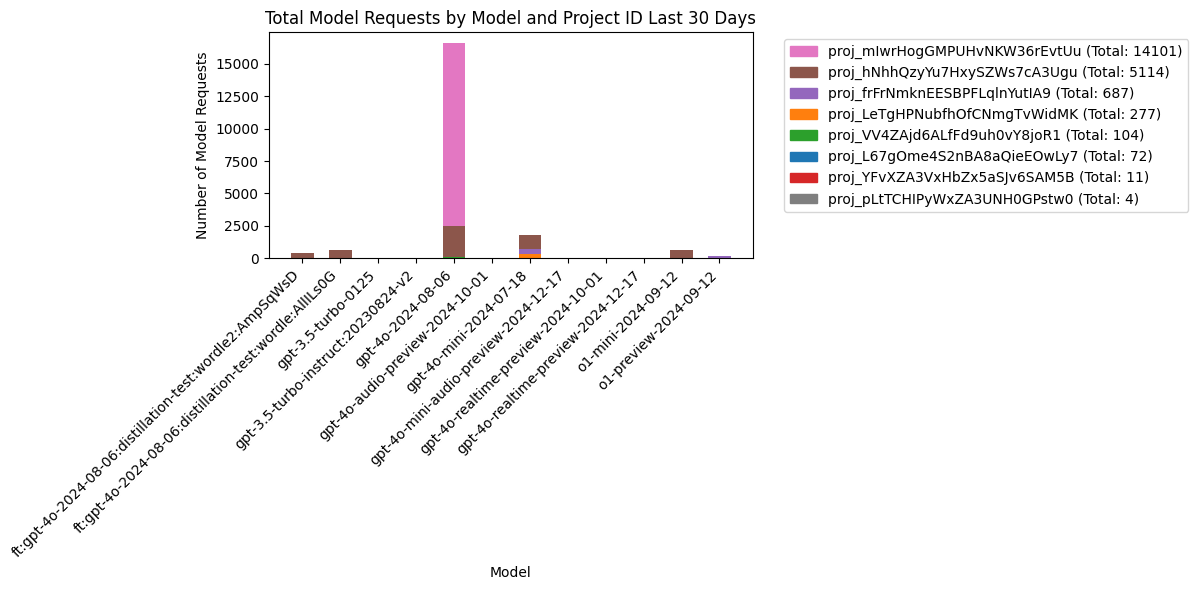

In [8]:
# Group data by model and project_id and aggregate model request counts
grouped_by_model_project = (
    df.groupby(["model", "project_id"])
    .agg({
        "num_model_requests": "sum",
    })
    .reset_index()
)

# Determine unique models and project IDs for plotting and color mapping
models = sorted(grouped_by_model_project['model'].unique())
project_ids = sorted(grouped_by_model_project['project_id'].unique())
distinct_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]
project_color_mapping = {pid: distinct_colors[i % len(distinct_colors)] for i, pid in enumerate(project_ids)}

# Calculate total number of requests per project_id for legend
project_totals = (
    grouped_by_model_project.groupby("project_id")["num_model_requests"].sum()
    .sort_values(ascending=False)  # Sort by highest total first
)

# Set up bar positions
n_models = len(models)
bar_width = 0.6
x = np.arange(n_models)

plt.figure(figsize=(12, 6))

# Plot stacked bars for each model
for model_idx, model in enumerate(models):
    # Filter data for the current model
    model_data = grouped_by_model_project[grouped_by_model_project['model'] == model]
    
    bottom = 0
    # Stack segments for each project ID within the bars
    for _, row in model_data.iterrows():
        color = project_color_mapping[row['project_id']]
        plt.bar(x[model_idx], row['num_model_requests'], width=bar_width,
                bottom=bottom, color=color)
        bottom += row['num_model_requests']

# Labeling and styling
plt.xlabel('Model')
plt.ylabel('Number of Model Requests')
plt.title('Total Model Requests by Model and Project ID Last 30 Days')
plt.xticks(x, models, rotation=45, ha="right")

# Create a sorted legend with totals
handles = [
    mpatches.Patch(
        color=project_color_mapping[pid],
        label=f"{pid} (Total: {total})"
    )
    for pid, total in project_totals.items()
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Visual Example: Model Distribution Pie Chart

This section visualizes the distribution of token usage across different models using a pie chart.


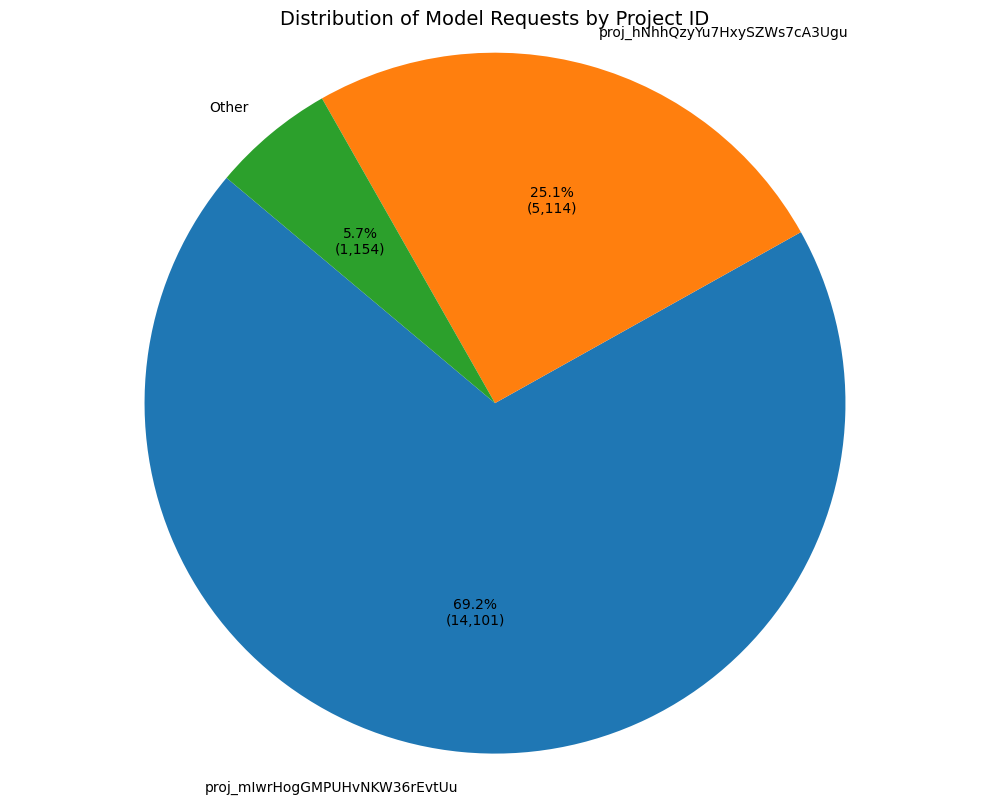

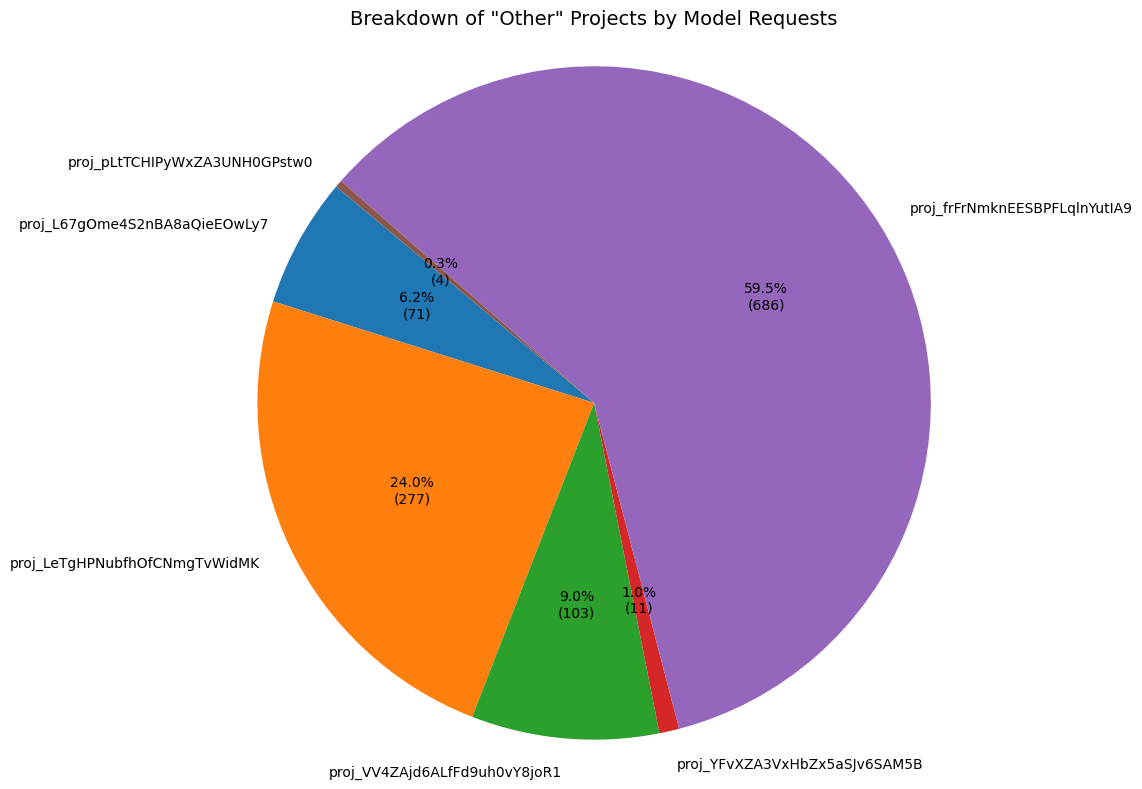

In [9]:
records = []
for bucket in all_group_data:
    for result in bucket.get("results", []):
        records.append({
            "project_id": result.get("project_id", "N/A"),
            "num_model_requests": result.get("num_model_requests", 0),
        })

# Create a DataFrame
df = pd.DataFrame(records)

# Aggregate data by project_id
grouped_by_project = (
    df.groupby("project_id")
    .agg({"num_model_requests": "sum"})
    .reset_index()
)

# Visualize Pie Chart
if not grouped_by_project.empty:
    # Filter out rows where num_model_requests == 0
    filtered_grouped_by_project = grouped_by_project[grouped_by_project['num_model_requests'] > 0]
    
    # Calculate the total model requests after filtering
    total_requests = filtered_grouped_by_project['num_model_requests'].sum()
    
    if total_requests > 0:
        # Calculate percentage of total for each project
        filtered_grouped_by_project['percentage'] = (
            filtered_grouped_by_project['num_model_requests'] / total_requests
        ) * 100
        
        # Separate "Other" projects (below 5%)
        other_projects = filtered_grouped_by_project[filtered_grouped_by_project['percentage'] < 5]
        main_projects = filtered_grouped_by_project[filtered_grouped_by_project['percentage'] >= 5]
        
        # Sum up "Other" projects
        if not other_projects.empty:
            other_row = pd.DataFrame({
                "project_id": ["Other"],
                "num_model_requests": [other_projects['num_model_requests'].sum()],
                "percentage": [other_projects['percentage'].sum()]
            })
            filtered_grouped_by_project = pd.concat([main_projects, other_row], ignore_index=True)
        
        # Sort by number of requests for better legend organization
        filtered_grouped_by_project = filtered_grouped_by_project.sort_values(by="num_model_requests", ascending=False)
        
        # Main pie chart for distribution of model requests by project_id
        plt.figure(figsize=(10, 8))
        plt.pie(
            filtered_grouped_by_project['num_model_requests'], 
            labels=filtered_grouped_by_project['project_id'], 
            autopct=lambda p: f'{p:.1f}%\n({int(p * total_requests / 100):,})',
            startangle=140,
            textprops={'fontsize': 10}
        )
        plt.title('Distribution of Model Requests by Project ID', fontsize=14)
        plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular.
        plt.tight_layout()
        plt.show()
        
        # If there are "Other" projects, generate a second pie chart for breakdown
        if not other_projects.empty:
            other_total_requests = other_projects['num_model_requests'].sum()
            
            plt.figure(figsize=(10, 8))
            plt.pie(
                other_projects['num_model_requests'], 
                labels=other_projects['project_id'], 
                autopct=lambda p: f'{p:.1f}%\n({int(p * other_total_requests / 100):,})',
                startangle=140,
                textprops={'fontsize': 10}
            )
            plt.title('Breakdown of "Other" Projects by Model Requests', fontsize=14)
            plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular.
            plt.tight_layout()
            plt.show()
    else:
        print("Total model requests is zero. Pie chart will not be rendered.")
else:
    print("No grouped data available for pie chart.")

## Costs API Example

In this section, we'll work with the OpenAI Costs API to retrieve and visualize cost data. Similar to the completions data, we'll:
- Call the Costs API to get aggregated cost data.
- Parse the JSON response into a pandas DataFrame.
- Visualize costs grouped by line item using a bar chart.

In [10]:
# Calculate start time: n days ago from now
days_ago = 30
start_time = int(time.time()) - (days_ago * 24 * 60 * 60)

# Define the Costs API endpoint
costs_url = "https://api.openai.com/v1/organization/costs"

# Initialize an empty list to store all data
all_costs_data = []

# Initialize pagination cursor
page_cursor = None

# Loop to handle pagination
while True:
    costs_params = {
        "start_time": start_time,  # Required: Start time (Unix seconds)
        "bucket_width": "1d",  # Optional: Currently only '1d' is supported
        "limit": 30,  # Optional: Number of buckets to return
    }

    # Update the page cursor in parameters if it exists
    if page_cursor:
        costs_params["page"] = page_cursor

    # Make the Costs API request
    costs_response = requests.get(costs_url, headers=headers, params=costs_params)

    # Check if the request was successful
    if costs_response.status_code == 200:
        costs_json = costs_response.json()
        all_costs_data.extend(costs_json.get("data", []))  # Append current page data to all_costs_data

        # Check if there's a next page
        page_cursor = costs_json.get("next_page")
        if not page_cursor:
            break  # Exit loop if no more pages
    else:
        print(f"Error: {costs_response.status_code}")
        break  # Exit loop on error

# Check if data was successfully retrieved
if all_costs_data:
    print("Costs data retrieved successfully!")
else:
    print("No costs data found.")


Costs data retrieved successfully!


## Parse the Costs API Response and Create a DataFrame

We will now parse the JSON data from the Costs API, extract relevant fields, and create a pandas DataFrame for further analysis.


In [11]:
# Initialize a list to hold parsed cost records
cost_records = []

# Extract bucketed cost data from all_costs_data
for bucket in all_costs_data:
    start_time = bucket.get("start_time")
    end_time = bucket.get("end_time")
    for result in bucket.get("results", []):
        cost_records.append({
            "start_time": start_time,
            "end_time": end_time,
            "amount_value": result.get("amount", {}).get("value", 0),
            "currency": result.get("amount", {}).get("currency", "usd"),
            "line_item": result.get("line_item"),
            "project_id": result.get("project_id")
        })

# Create a DataFrame from the cost records
cost_df = pd.DataFrame(cost_records)

# Convert Unix timestamps to datetime for readability
cost_df['start_datetime'] = pd.to_datetime(cost_df['start_time'], unit='s')
cost_df['end_datetime'] = pd.to_datetime(cost_df['end_time'], unit='s')

# Display the first few rows of the DataFrame
cost_df.head()

,start_time,end_time,amount_value,currency,line_item,project_id,start_datetime,end_datetime
0,1734307200,1734393600,55.358578,usd,None,None,2024-12-16,2024-12-17
1,1734393600,1734480000,0.000110,usd,None,None,2024-12-17,2024-12-18
2,1734480000,1734566400,0.016204,usd,None,None,2024-12-18,2024-12-19
3,1734566400,1734652800,2.121425,usd,None,None,2024-12-19,2024-12-20
4,1734652800,1734739200,3.771420,usd,None,None,2024-12-20,2024-12-21


## Visualize Costs by Line Item

We'll create a bar chart to visualize the total costs aggregated by line item. This helps identify which categories (e.g., models or other services) contribute most to the expenses.


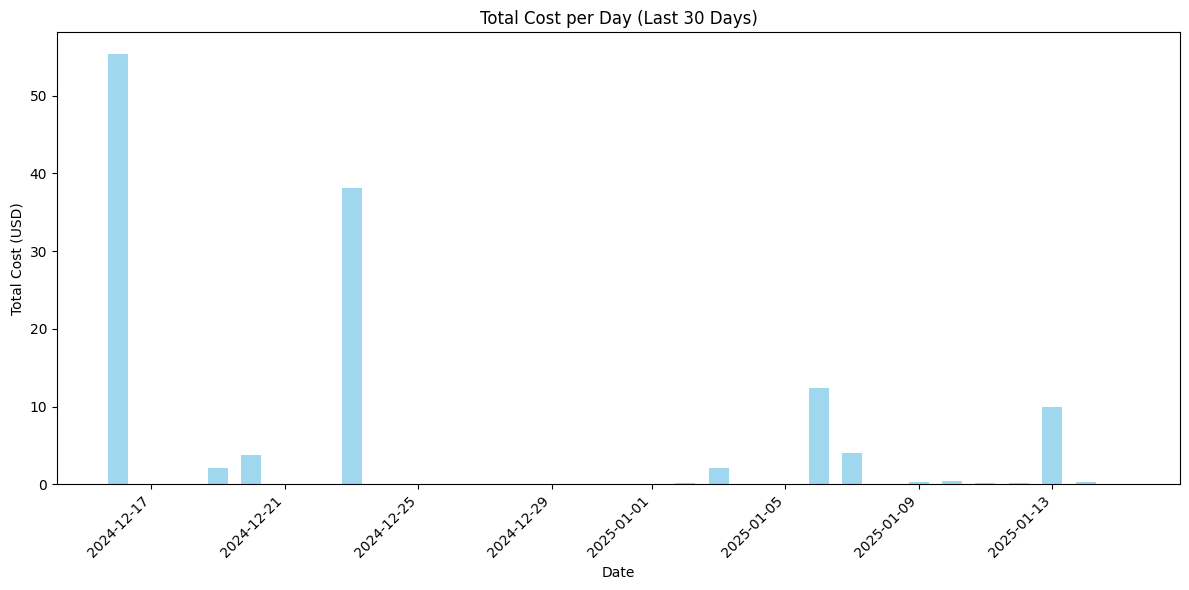

In [12]:
if not cost_df.empty:
    # Ensure datetime conversion for 'start_datetime' column
    if 'start_datetime' not in cost_df.columns or not pd.api.types.is_datetime64_any_dtype(cost_df['start_datetime']):
        cost_df['start_datetime'] = pd.to_datetime(cost_df['start_time'], unit='s', errors='coerce')

    # Create a new column for just the date part of 'start_datetime'
    cost_df['date'] = cost_df['start_datetime'].dt.date
    
    # Group by date and sum the amounts
    cost_per_day = cost_df.groupby('date')['amount_value'].sum().reset_index()
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.bar(cost_per_day['date'], cost_per_day['amount_value'], width=0.6, color='skyblue', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('Total Cost (USD)')
    plt.title('Total Cost per Day (Last 30 Days)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No cost data available to plot.")

## Additional Visualizations (Optional)

You can extend this notebook with more visualizations for both the Completions and Costs APIs. For example:

**Completions API:**
- Group by user, project, or model to see which ones consume the most tokens.
- Create line plots for time series analysis of token usage over days or hours.
- Use pie charts to visualize distribution of tokens across models, users, or projects.
- Experiment with different `group_by` parameters (e.g., `["model", "user_id"]`) to gain deeper insights.

**Costs API:**
- Group by project or line item to identify spending patterns.
- Create line or bar charts to visualize daily cost trends.
- Use pie charts to show how costs are distributed across projects, services, or line items.
- Try various `group_by` options (e.g., `["project_id"]`, `["line_item"]`) for granular analysis.

Experiment with different parameters and visualization techniques using `pandas` and `matplotlib` (or libraries like Plotly/Bokeh) to gain deeper insights, and consider integrating these visualizations into interactive dashboards for real-time monitoring.


## Integrating with Third-Party Dashboarding Platforms

To bring OpenAI usage and cost data into external dashboarding tools like Tableau, Power BI, or custom platforms (e.g., Plotly Dash, Bokeh), follow these steps:

1. **Data Collection & Preparation:**
   - Use Python scripts to regularly fetch data from the Completions and Costs APIs.
   - Process and aggregate the data with pandas, then store it in a database, data warehouse, or export it as CSV/JSON files.

2. **Connecting to a Dashboard:**
   - **BI Tools (Tableau, Power BI):**
     - Connect directly to the prepared data source (SQL database, CSV files, or web APIs).
     - Use built-in connectors to schedule data refreshes, ensuring dashboards always display current information.
   - **Custom Dashboards (Plotly Dash, Bokeh):**
     - Embed API calls and data processing into the dashboard code.
     - Build interactive visual components that automatically update as new data is fetched.

3. **Real-Time & Automated Updates:**
   - Schedule scripts using cron jobs, task schedulers, or workflow tools (e.g., Apache Airflow) to refresh data periodically.
   - Implement webhooks or streaming APIs (if available) for near real-time data updates.

By integrating API data into third-party platforms, you can create interactive, real-time dashboards that combine OpenAI metrics with other business data, offering comprehensive insights and automated monitoring.
